In [29]:
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [30]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Time")
    plt.grid(True)

In [31]:
import pandas as pd

df = pd.read_csv ('/Users/sachinmalik/Downloads/Workbook/Workbook.csv')
print (df)

     SNO       NAME          ADDRESS       PIN  CONTACT NUMBER  BIN NUMBER  \
0    1.0   Darshith  palam extension  110077.0    9.525847e+09        56.0   
1    2.0   Darshith  palam extension  110077.0    9.525847e+09        56.0   
2    3.0      Darun  palam extension  110077.0    9.525847e+09        56.0   
3    4.0      James  palam extension  110077.0    9.525847e+09        56.0   
4    5.0  Josephine  palam extension  110077.0    9.525847e+09        56.0   
..   ...        ...              ...       ...             ...         ...   
307  NaN        NaN              NaN       NaN             NaN         NaN   
308  NaN        NaN              NaN       NaN             NaN         NaN   
309  NaN        NaN              NaN       NaN             NaN         NaN   
310  NaN        NaN              NaN       NaN             NaN         NaN   
311  NaN        NaN              NaN       NaN             NaN         NaN   

     LALITUDE  LONGITUDE        DATE       DAY     TIME  
0    

In [32]:
bindate = []
bintime = []
for index, row in df.iterrows():
                if (not(np.isnan(row['SNO']))):
                        bindate.append(str((row['DATE']) ))
                        bintime.append(str(row['TIME']))

In [33]:
def time_to_sec(t):
   h, m, s = map(int, t.split(':'))
   return h * 3600 + m * 60 + s



In [34]:
temptime1 = []
for x in bintime:
  temptime1.append(time_to_sec(x))

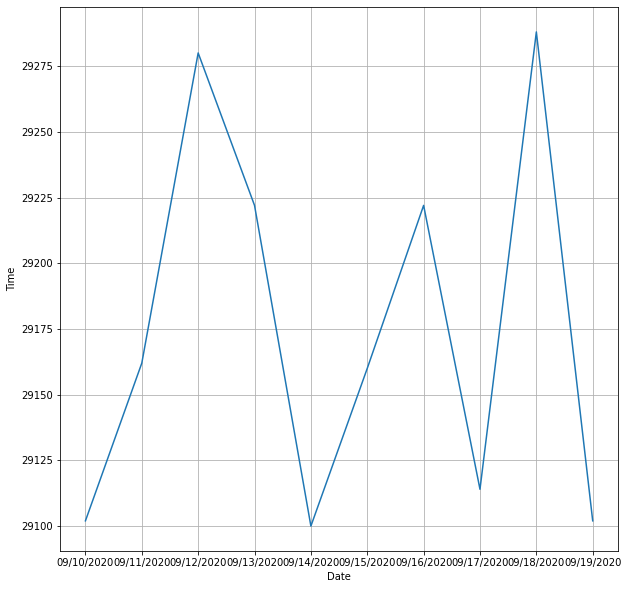

In [35]:
DateBin = np.array(bindate)
TimeBin = np.array(temptime1)
tempdate = DateBin[:10]
temptime = TimeBin[:10]
plt.figure(figsize=(10, 10))
plot_series(tempdate, temptime)

In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [37]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(TimeBin, window_size=10, batch_size=10, shuffle_buffer=2)

In [39]:
modelA = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizerA = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
modelA.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizerA,
              metrics=["mae"])
historyA = modelA.fit(train_set,epochs=50)

Epoch 1/50
29/29 [==============================] - 6s 14ms/step - loss: 28018.9160 - mae: 28019.4102
Epoch 2/50
29/29 [==============================] - 0s 13ms/step - loss: 8143.4492 - mae: 8143.9517

In [40]:
rnn_forecastA = model_forecast(modelA, temptime[..., np.newaxis], 2)
rnn_forecastA = rnn_forecastA[9 - 2:-1, -1, 0]

In [41]:
print(rnn_forecastA)

[28863.18]


In [42]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "The predicted time for the next day is %d:%02d:%02d" % (hour, minutes, seconds)

In [43]:
for x in rnn_forecastA:
  print(convert(x))


The predicted time for the next day is 8:01:03
